In [1]:
import numpy as np
import autolens as al
import autogalaxy as ag
import autolens.plot as aplt
import os
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
from autolens.plot import MatPlot2D

from photutils import DAOStarFinder, CircularAperture
from astropy.stats import sigma_clipped_stats
# from autolens.plot import ArrayPlotter
%load_ext autoreload

import sys
from pathlib import Path

base_dir = Path.cwd()
autolens_config_path = base_dir / "autolens_config"
spherex_path = base_dir / "SPHEREx"

sys.path.append(str(autolens_config_path))
sys.path.append(str(spherex_path))


#import gcluster15  # from autolens_config
import SPHERExScripts as SPHEREx  # from SPHEREX
import gcluster15 as galaxy
import autolens_config



2025-02-13 13:24:25,859 - numexpr.utils - INFO - Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2025-02-13 13:24:25,860 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


<ipython-input-1-ce71f95b90cd>:11: DeprecationWarning: `photutils.DAOStarFinder` is a deprecated alias for `photutils.detection.DAOStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import DAOStarFinder` to silence this warning.
  from photutils import DAOStarFinder, CircularAperture
<ipython-input-1-ce71f95b90cd>:11: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import DAOStarFinder, CircularAperture


In [20]:
%autoreload 2

## Here are some properties about the galaxy clusters we are studying and simulating I want to note 
***

First of all, we want to look at *rich* galaxy clusers (N_gal >= 30). Rich galaxy clusters are known to be proponents of strong lensing. We can see this from the papers:
- [https://ui.adsabs.harvard.edu/abs/2011RAA....11.1185W/]
- [https://ui.adsabs.harvard.edu/abs/2009RAA.....9....5W/]
- [https://ui.adsabs.harvard.edu/abs/2014SCPMA..57.1809L/]

However, we need some way to parametrize the mass and light given the number of galaxies and redshift. After all, we are creating mass and light profiles so that PyAutoLens can perform raytracing. 

We can use the results from [https://iopscience.iop.org/article/10.1086/444554/pdf]:
* $R^{N}_{200} \sim N^{0.6}_{gal}$, powerlaw related by index $\approx -0.6$

* $M_{200} \sim N^{1.8}_{gal}$ 

* $M^{1/3}_{200} \sim N^{1/3\alpha\beta}_{gal}$ where $(1/3\alpha\beta) \approx 0.6$ and $\beta$ in the range $\sim 0.5 - 0.65$ and $\alpha$ ranges depending on $N_{gal}$, but $\alpha =-1$ for $N_{gal} > 8$
Where $R^{N}_{200}$ is the characteristic radius, $N_{gal}$ is the cluster richness, and the $200$ subscript denotes the virial term. 


Now, we need to model the dark matter halo. Going off what Cooray said, we can have the dark matter halo as about 30" in radius. However, It would be better if we had a better estimate related to the number of galaxies. 

We can describe the dark matter profile of a galaxy using an NFW:
- [https://iopscience.iop.org/article/10.1086/500288/pdf]
- [https://arxiv.org/pdf/astro-ph/9508025]
- [https://iopscience.iop.org/article/10.1088/0004-637X/729/2/127/pdf]
- [https://iopscience.iop.org/article/10.1086/308744/pdf]


We also need to figure out how to distribute the galaxies within the plane of the 2D image. We can use the standard power law formula for the distribution:
- $n(R) \propto (1 + R/R_c)^{-\alpha}$

where $R$ is the cluster centric radius (the distance from the galaxy to the center of the cluster, which in our case will always be the center of the plane) and $R_c$ is the cluster radius. 

---
#### Simulation
Since PyAutoLens does not have formal support for creating galaxy clusters, we have to create each individual galaxy. We can break this down into mass profiles, and light profiles. 

In the case of the mass profile, the NFW dark matter halo will dominate the galaxy cluster's mass distribution. The percentage that it take is approximately 90%.
- (https://ui.adsabs.harvard.edu/abs/1996ApJ...462..563N/abstract)
- (https://www.mdpi.com/2075-4434/7/1/8)
- (https://www.nature.com/articles/s41586-020-2642-9)
Therefore, we can accurately model the mass profile with the dark matter halo NFW. Perhaps we can try adding in a small correction due to some extraneously dense galaxy, but such an implementation is not necessary for now. 

I am not entirely sure how to model this off based on the number of galaxies. I'm not sure if it should


We also need to model the light profile. This one is more tricky, for obvious reasons. 
Naively, we can create a random sersic light profile for every single galaxy in the cluster, add all the galaxies to our galaxy cluster, and we have a light profile for our cluster. However, this is computationally expensive and not exactly accurate. 

Here are some facts we know about galaxy clusters, their member galaxies and their light profiles. 
- They can be described by sersic profiles

- There exists a "brightest" galaxy within the cluster, positioned near the center of the cluster, which can take up to 36% of the total light profile. (https://arxiv.org/pdf/astro-ph/0001415)

- There are a range of luminous galaxy members, but we will proceed by truncating their contributions under a certain apparent magnitude. This is to reduce computaional intensity. We can allow the medium range luminous galaxies to have a light profile within a certain random range. 


Now, we need to get the flux to pixel ratio correct. After all, these are going to be placed into the background of images from the merged catalog of DESI + Subaru legacy surveys. 
From what I can see, this has to be aligned with the pixel scales from marco's images. 



In [3]:
# imageRaw = galaxy.wrapperFunction()

Datasets in file: ['raw_outputs']


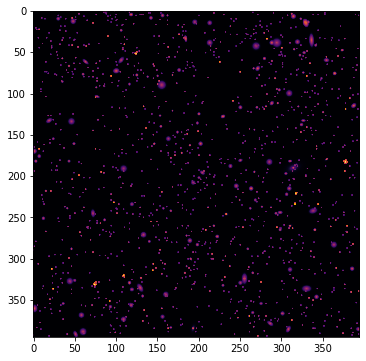

In [2]:
file_path = "output/simulatedBackgrounds395pixels.h5"

with h5py.File(file_path, "r") as h5_file:
    # List available datasets
    print("Datasets in file:", list(h5_file.keys()))
    
    dataset_name = list(h5_file.keys())[0]  # Select the dataset, should be called raw_data
    images = h5_file[dataset_name][()]  # Load the dataset into a NumPy array

# Display the first image
norm = mpl.colors.SymLogNorm(linthresh=0.005)

plt.figure(figsize=(6, 6))
plt.imshow(images[1], cmap="inferno", norm=norm)  # Assuming grayscale images
# plt.colorbar()
# plt.title("First Image in simulated1.h5")
plt.show()

In [3]:
import sys
from pathlib import Path

base_dir = Path.cwd()
autolens_config_path = base_dir / "autolens_config"

sys.path.append(str(autolens_config_path))


#import gcluster15  # from autolens_config
import gcluster16 as galaxy
import autolens_config
%autoreload 2

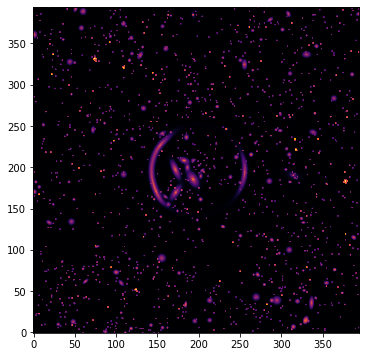

In [33]:
%autoreload 2
background = images[1]
fake = np.array([None, None])
multiple = False

combined_raw = galaxy.wrapperFunction(10, background, multiple)

# background = images[0]
# overlay_image = background + imageRaw

plt.figure(figsize=(6, 6))

plt.imshow(combined_raw, cmap="inferno", origin="lower", norm=mpl.colors.SymLogNorm(linthresh=0.005))
# plt.set_title("Cluster Overlaid on Background")
# plt.set_xlabel("X Coordinate")
# plt.set_ylabel("Y Coordinate")
# plt.colorbar(label="Intensity")

# plt.tight_layout()
plt.show()


In [35]:
import h5py

with h5py.File("lensed_images.h5", "w") as f:
    f.create_dataset("image1", data=combined_raw)
    #f.create_dataset("image2", data=another_image_array)  # Add more images

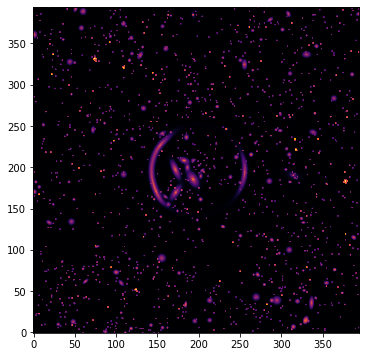

In [37]:
with h5py.File("lensed_images.h5", "r") as f:
    image1 = f["image1"][:]
    # image2 = f["image2"][:]

plt.figure(figsize=(6, 6))

plt.imshow(image1, cmap="inferno", origin="lower", norm=mpl.colors.SymLogNorm(linthresh=0.005))
# plt.set_title("Cluster Overlaid on Background")
# plt.set_xlabel("X Coordinate")
# plt.set_ylabel("Y Coordinate")
# plt.colorbar(label="Intensity")

# plt.tight_layout()
plt.show()

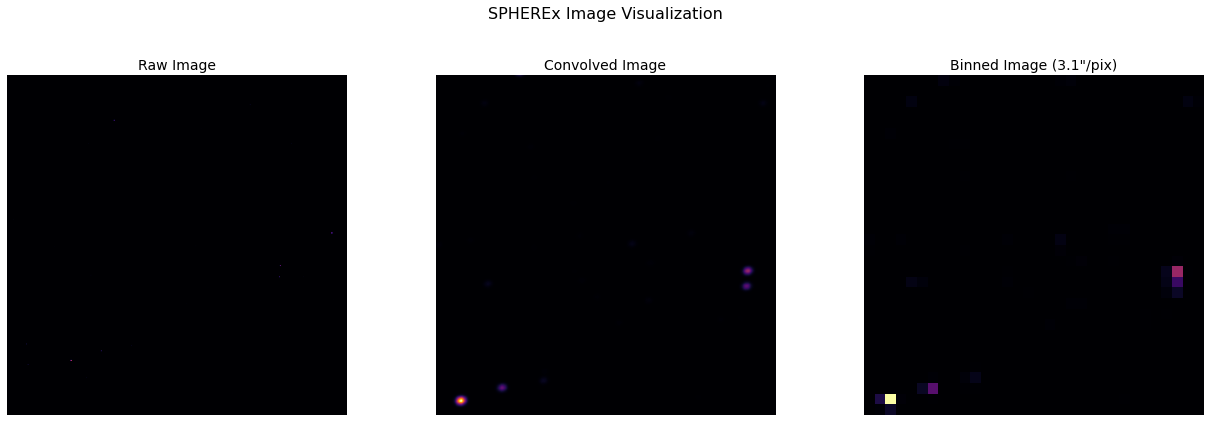

In [13]:
convolved, binned = SPHEREx.processImg(combined_raw)
SPHEREx.plotImg(raw_image=combined_raw,convolved=convolved,binned=binned)

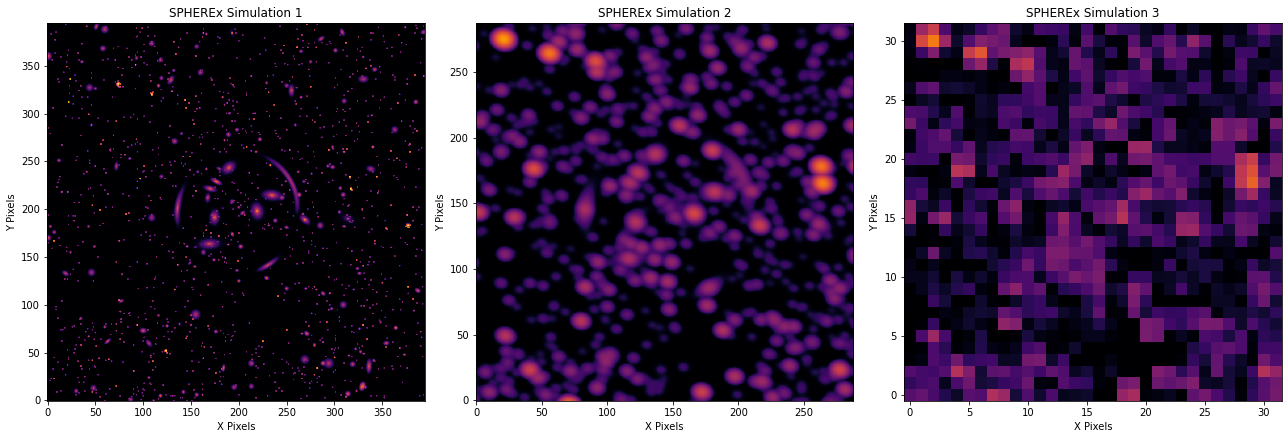

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Example data (replace with your actual images)
data1, data2, data3 = combined_raw, convolved,binned  # Replace with actual image data

norm = mpl.colors.SymLogNorm(linthresh=0.005)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# List of data and titles
data_list = [data1, data2, data3]
titles = ["SPHEREx Simulation 1", "SPHEREx Simulation 2", "SPHEREx Simulation 3"]

for i, ax in enumerate(axes):
    im = ax.imshow(data_list[i], cmap='inferno', origin='lower', norm=norm)
    ax.set_title(titles[i])
    ax.set_xlabel("X Pixels")
    ax.set_ylabel("Y Pixels")

# Add a single colorbar for all subplots
#fig.colorbar(im, ax=axes.ravel().tolist(), label="Flux")

plt.tight_layout()
plt.show()

## Citations
- https://ui.adsabs.harvard.edu/abs/2011RAA....11.1185W/
- https://ui.adsabs.harvard.edu/abs/2009RAA.....9....5W/
- https://ui.adsabs.harvard.edu/abs/2014SCPMA..57.1809L/
- https://iopscience.iop.org/article/10.1086/444554/pdf
- https://arxiv.org/pdf/1809.03325
- https://www.frontiersin.org/journals/astronomy-and-space-sciences/articles/10.3389/fspas.2024.1411810/full
- https://arxiv.org/pdf/2111.08721
- https://arxiv.org/pdf/2111.08721
- https://www.aanda.org/articles/aa/full_html/2013/07/aa21268-13/aa21268-13.html
- https://iopscience.iop.org/article/10.1086/340952/pdf
- https://www.researchgate.net/figure/The-Sersic-profile-equation-1-describes-how-a-galaxy-light-profile-varies-as-a-function_fig2_234382030
- https://arxiv.org/pdf/astro-ph/0001415
- https://www.aanda.org/articles/aa/full_html/2021/05/aa40245-20/aa40245-20.html
- 

In [ ]:
# Below is code that shouldnt be run

In [5]:
def sample_radius(n, r_c, r_min=0.01, r_max=10, alpha=-1):
    """
    Samples `n` radial distances based on the formula:
    n(R) ∝ (1 + R / R_c)^(-alpha)
    """
    def cdf(r):
        # Integrate the probability density function (PDF)
        return (r_c / (alpha)) * ((1 + r / r_c)**(alpha) - (1 + r_min / r_c)**(alpha))

    cdf_min = cdf(r_min)
    cdf_max = cdf(r_max)

    # Inverse transform sampling
    u = np.random.uniform(0, 1, n)
    r_samples = r_c * ((u * (cdf_max - cdf_min) + cdf_min) * (alpha) / r_c + (1 + r_min / r_c)**(alpha))**(1 / (alpha))
    return r_samples

def generate_cluster(
        n_members, 
        cluster_center,
        redshift
):
    galaxies = []

    coords = cluster_center # Should be a tuple of coords

    # define halo
    cluster_halo_profile = al.mp.gNFW(
        centre=coords,
        ell_comps=(
            np.random.uniform(-0.2, 0.2),
            np.random.uniform(-0.2, 0.2),
        ),
        # Kappa = The overall normalization of the dark matter halo 
        # (kappa_s = (rho_s * scale_radius)/lensing_critical_density)
        kappa_s = np.random.uniform(0.1,0.3),
        # Scale radius is the Characteristic radius
        # Not sure how this is exactly related to Ngal
        # Cooray said should be like 30 up to 60
        scale_radius = np.random.uniform(30.0,45.0),
        inner_slope=1.0
    )

    dark_halo = al.Galaxy(redshift=redshift, mass=cluster_halo_profile)
    galaxies.append(dark_halo)

    bcg_light_profile = al.lp.Sersic(
    centre=(np.random.uniform(0.0,1.0), np.random.uniform(0.0,1.0)),  # at or near cluster center
    ell_comps=(0.1, 0.2),
    intensity=10.0,  # Very high luminosity
    effective_radius=10.0,
    sersic_index=4.0,  # De Vaucouleurs profile
    )

    bcg = al.Galaxy(
        redshift=redshift,
        bulge=bcg_light_profile,
    )

    galaxies.append(bcg)


    r_c = n_members**(0.6)

    # form the cluster members
    for _ in range(n_members):
        # Implement the powerlaw falling off for galaxies away from center
        # Generate radius and angle
        r = sample_radius(1, r_c)[0]  # Draw a single radius
        theta = np.random.uniform(0, 2 * np.pi)  # Random angle for isotropic distribution

        # Convert to Cartesian coordinates
        x = r * np.cos(theta)
        y = r * np.sin(theta)

        center = (x,y) # Might be center - x,y
        ell_comps=(
            np.random.uniform(-0.3, 0.3),
            np.random.uniform(-0.3, 0.3)
        )
        # Sersic mass profile seems to be the best. Might combine well with sersic light profile
        mass_profile = al.mp.Sersic(
            centre=center,
            ell_comps=ell_comps
        )

        # We need to handle this a bit more carefully. Perhaps create the brightest seperately. 
        # We also perform truncation at a certain point
        base_intense = np.random.uniform(3.0,15.0)
        intense = base_intense*(1/(1+r/r_c)) # higher for closer to center
        light_profile = al.lp.Sersic(
            centre=center,
            ell_comps=ell_comps,
            intensity=intense,
            effective_radius=intense*1.5,
            sersic_index=np.random.uniform(1.0,4.0)
        )

        galaxy = al.Galaxy(
            redshift=redshift,
            mass = mass_profile,
            bulge = light_profile
        )

        galaxies.append(galaxy)


    return galaxies


def source_galaxy(
        source_center,
        redshift
):
    light_profile = al.lp.Sersic()

    source_galaxy = al.Galaxy(
        redshift=redshift,
        bulge = light_profile
    )

    return source_galaxy

def simulate_lensing():
    return None

def simulate_no_lensing(
        n_members,
        cluster_center,
        redshift,
        shape_native,
        background_image,
        pixel_scales,
        plot_result=True
):
    
#     mean, median, std = sigma_clipped_stats(background_image, sigma=3.0)

# # Detect sources
#     daofind = DAOStarFinder(fwhm=3.0, threshold=5.0 * std)
#     sources = daofind(background_image - median)

#     # Extract properties
#     positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
#     fluxes = sources['flux']
#     fwhms = sources['fwhm']
#     ellipticity = sources['sharpness']  # Approximation

    cluster = generate_cluster(n_members, cluster_center, redshift)

    background = al.Array2D(
        values = background_image,
        pixel_scales = pixel_scales
    )

    psf = al.Kernel2D.from_gaussian( # We need this to be spherex quality
        shape_native=(),
        sigma=0.1,
        pixel_scales=pixel_scales
    )
    # grid = al.Grid2D.uniform

    simulator = al.SimulatorImaging(
        exposure_time=100,
        background_image = background,
    )

    imaging = simulator.via_galaxies_from(
        galaxies=cluster,
        grid=0 # Change, maybe dont need grid
    )


    return imaging

